In [1]:
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(str(repo.working_tree_dir) + '/src')

In [2]:
import numpy as np
import pandas as pd 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression

from src.demos import prepare_data, plot_data, plot_revenue_per_weekday, plot_avg_revenue_per_weekday, create_test_and_train_set, plot_revenue
from src.model import time_series_cross_validation_arima
%matplotlib inline 
%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=2)

**Data Preperation**

In [3]:
wheater_path = repo.working_tree_dir + '/data/wheater_data.csv' 
revenue_path = repo.working_tree_dir + '/data/revenue_data.csv' 
df = prepare_data(wheater_path, revenue_path)
train_df, test_df = create_test_and_train_set(df)

/Users/jonasfischer/Library/CloudStorage/OneDrive-Persönlich/Projekte/Restaurant-Revenue-Forecasting/src/demos.py:170: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.yesterday_revenue.iloc[0] = df.revenue.iloc[0]
/Users/jonasfischer/Libra

/Users/jonasfischer/Library/CloudStorage/OneDrive-Persönlich/Projekte/Restaurant-Revenue-Forecasting/src/demos.py:231: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(g.ax.get_xticklabels(), fontsize=7)


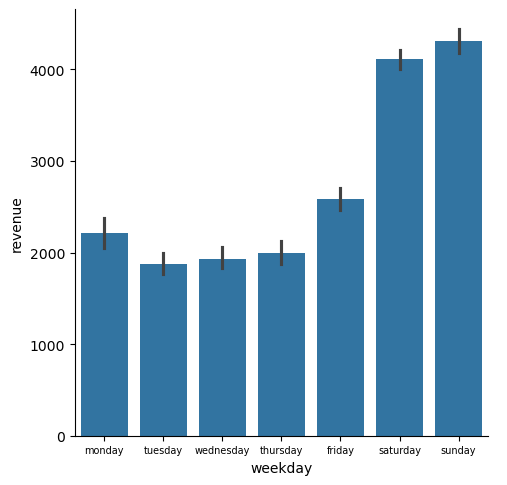

In [4]:
plot_avg_revenue_per_weekday(df)

**Arima Model**


In [5]:
from model import split_X_Y

In [16]:
X_train, Y_train = split_X_Y(train_df)
X_test, Y_test = split_X_Y(test_df)

In [7]:
Y_train.head()

date
2022-06-01    1000
2022-06-02    1641
2022-06-03    2254
2022-06-04    4306
2022-06-05    4289
Name: revenue, dtype: int64

In [8]:
import optuna

In [9]:
def objective_arima(trial):
    params = {
        'p': trial.suggest_int('p',1,30),
        'd': trial.suggest_int('d',0,30),
        'q': trial.suggest_int('q',0,30),
        'trend': trial.suggest_categorical('trend', ['n', 'c', 't', 'ct'])
    }

    err = time_series_cross_validation_arima(train_df, params, plot_data=False)

    return err

In [11]:
model = LinearRegression()

In [14]:
model = model.fit(X_train, Y_train)

In [23]:
predictions = model.predict(X_train)

In [19]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [24]:
MAPE(predictions, Y_train)

0.17766266625955338

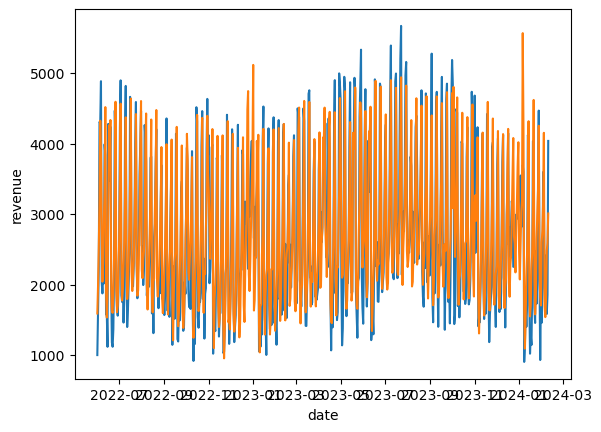

In [25]:
plot_revenue(train_df, predictions)

In [31]:
residuals = train_df.copy()
residuals['revenue'] -= predictions

In [32]:
residuals.head(10)

,tavg,tmin,tmax,prcp,wdir,wspd,pres,national_holiday,holiday,revenue,...,national_and_holiday,DOW,yesterday_revenue,three_day_revenue,week_revenue,bridge_day,day,month,year,predictions
date,,,,,,,,,,,,,,,,,,,,,
2022-06-01,16.5,10.0,22.0,0.1,281,9.9,1015.0,0,0,-589.940850,...,0,2,1000.0,1000.000000,1000.000000,0,1,6,2022,1589.940850
2022-06-02,16.8,8.4,22.3,0.0,56,7.2,1019.4,0,0,-346.052674,...,0,3,1000.0,1000.000000,1000.000000,0,2,6,2022,1987.052674
2022-06-03,19.9,14.6,27.7,0.5,79,9.4,1016.3,0,0,-256.765382,...,0,4,1641.0,1320.500000,1320.500000,0,3,6,2022,2510.765382
2022-06-04,20.8,14.5,25.8,0.0,67,6.7,1017.2,0,0,1105.911082,...,0,5,2254.0,1631.666667,1631.666667,0,4,6,2022,3200.088918
2022-06-05,20.1,16.9,23.1,12.3,147,11.9,1014.9,0,0,-34.726671,...,0,6,4306.0,2733.666667,2300.250000,0,5,6,2022,4323.726671
2022-06-06,18.7,14.5,23.0,0.7,243,12.7,1016.9,1,0,1048.590137,...,0,0,4289.0,3616.333333,2698.000000,0,6,6,2022,3835.409863
2022-06-07,18.2,14.8,23.2,1.2,236,9.3,1014.9,0,1,-647.079661,...,0,1,4884.0,4493.000000,3062.333333,0,7,6,2022,2684.079661
2022-06-08,16.9,12.7,22.0,0.8,223,10.3,1011.0,0,1,-165.312980,...,0,2,2037.0,3736.666667,2915.857143,0,8,6,2022,2040.312980
2022-06-09,15.5,11.7,19.3,0.1,275,10.5,1015.0,0,1,-204.739215,...,0,3,1875.0,2932.000000,3040.857143,0,9,6,2022,2325.739215


In [33]:
import optuna
from src.model import time_series_cross_validation
import pickle
import xgboost as xgb

In [36]:
def objectiveTimeSeriesCV(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int('n_estimators',50,1000),
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    err = time_series_cross_validation(residuals, params, cv=4)
    return err

In [37]:
study = optuna.create_study(direction='minimize')
study.optimize(objectiveTimeSeriesCV, n_trials=100)

[I 2024-09-21 18:34:42,075] A new study created in memory with name: no-name-f9503b42-fb75-47c2-8e35-74941dcae01c
100%|██████████| 4/4 [00:01<00:00,  3.07it/s]
[I 2024-09-21 18:34:43,392] Trial 0 finished with value: 422240.3020381204 and parameters: {'n_estimators': 516, 'learning_rate': 0.08502476482105388, 'max_depth': 5, 'subsample': 0.0723213261471947, 'colsample_bytree': 0.6359374597578615, 'min_child_weight': 6}. Best is trial 0 with value: 422240.3020381204.
100%|██████████| 4/4 [00:01<00:00,  3.47it/s]
[I 2024-09-21 18:34:44,554] Trial 1 finished with value: 378698.6646955843 and parameters: {'n_estimators': 805, 'learning_rate': 0.0011052582163728903, 'max_depth': 1, 'subsample': 0.3775843577380335, 'colsample_bytree': 0.5807921553006338, 'min_child_weight': 12}. Best is trial 1 with value: 378698.6646955843.
100%|██████████| 4/4 [00:04<00:00,  1.12s/it]
[I 2024-09-21 18:34:49,031] Trial 2 finished with value: 316243.0949260867 and parameters: {'n_estimators': 396, 'learning_

In [39]:
paramsXGB = study.best_params

In [48]:
XGBoost = xgb.XGBRegressor(**paramsXGB)
XGBoost = XGBoost.fit(X_train, residuals['revenue'])

In [49]:
predictions_LR = model.predict(X_test)
predictions_XG = XGBoost.predict(X_test)

In [52]:
predHybrid = predictions_LR + predictions_XG

In [59]:
MAPE(predHybrid, Y_test)

0.17318095343291612

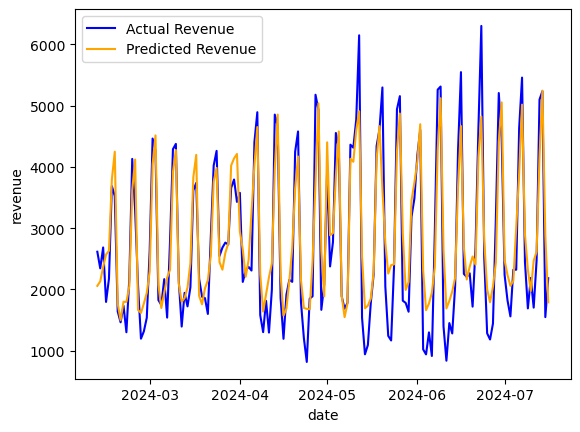

In [63]:
plot_revenue(test_df, predHybrid)